### Installation

In [ ]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.55.4
!pip install --no-deps trl==0.22.2

### Load Pretrained Model Qwen2.5 VL 7B using Unsloth

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

<a name="Data"></a>
### Data Preparation


*   We will be loading our sample_products.csv created EDA Task 1 and download the images.



In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2

from PIL import Image
import torch
from tqdm import tqdm

import humanize

DATA_DIR = "."

In [ ]:
data_df = pd.read_csv(f"{DATA_DIR}/sample_products.csv", dtype={"code": str})
print(data_df.shape)
data_df.head()

## Define Helpful Utility Functions
* To download image by given URL.
* To get the image and save it to directory.
* To create the product image path given the product code.
* To read the image from storage disk.

In [ ]:
import httpx
from io import BytesIO
from tenacity import retry, wait_fixed, stop_after_attempt

IMAGE_DIR = "./products_images"
os.makedirs(IMAGE_DIR, exist_ok=True)


def get_image_by_url(image_url: str, timeout_sec: int = 120) -> Image:
    with httpx.Client() as client:
        response = client.get(image_url, timeout=timeout_sec)
        return Image.open(BytesIO(response.content))

@retry(wait=wait_fixed(2), stop=stop_after_attempt(5))
def download_and_save(row: pd.Series):
    product_code = row['code']
    image_url = row['image_nutrition_url']

    if 'invalid' in image_url:
        image_url = image_url.replace('invalid', product_code)

    image_path = f"{IMAGE_DIR}/{product_code}.png"
    if not os.path.exists(image_path):
        try:
            image = get_image_by_url(image_url)
            image.save(image_path)
        except Exception as e:
            print("Failed to download image for url:", image_url)
            raise e


def get_product_image_path(product_code: str):
    return f"{IMAGE_DIR}/{product_code}.png"

def get_product_image(product_code: str) -> Image:
    try:
        return Image.open(get_product_image_path(product_code))
    except Exception as e:
        return Image.fromarray(np.zeros((512, 512, 3), dtype=np.uint8))

## Download Open Food Product Images using multi-processing.

In [ ]:
from multiprocessing import Pool
from tqdm import tqdm

NUM_WORKERS = 12

with Pool(processes=NUM_WORKERS) as pool:
    list(
            tqdm(
                pool.imap(download_and_save, [row for _, row in data_df[['code', 'image_nutrition_url']].iterrows()]),
                total=len(data_df),
                dynamic_ncols=True,
            )
        )

## Define function to create target Labels

In [ ]:
# Create target JSON
import json
from typing import Optional

ignore_attributes = ['nutrition-score-fr_100g']

def create_target_text_json(row, indent: Optional[int] = None):
    target_data = {}
    # Convert NaN values to None for JSON null
    for key, value in row.items():
        if key.endswith("_100g") and not pd.isna(value) and key not in ignore_attributes:
            target_data[key] = value

    return json.dumps(target_data, indent=indent)

## Target Label on example

In [ ]:
print(create_target_text_json(data_df.loc[4], indent=4))

In [ ]:
get_product_image(data_df.loc[4, 'code'])

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```

## Torch Dataset


*   Here, we define function to create conversation message.
*   Create Torch Dataset class for effective data loading while training.



In [ ]:
instruction = """Extract Nutrition Facts data from the given image. Normalize the nutrient values to 100g.
                 Return the extraction output in JSON.
                """

def convert_to_conversation(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": get_product_image(sample['code'])}
            ],
        },
        {"role": "assistant", "content": [{"type": "text", "text": sample["text"]}]},
    ]
    return {"messages": conversation}


class OpenFoodProductsOcrDataset(torch.utils.data.Dataset):

    def __init__(self, data_df: pd.DataFrame):
        self.df = data_df.reset_index(drop=True)
        self.df = self.df.sample(frac=1) # shuffle

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.loc[index]
        target_text = create_target_text_json(row)

        sample = convert_to_conversation({'code': row['code'], 'text': target_text})

        return sample

### Create Train - Val Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(
    data_df,
    test_size=0.15,  # 15% for validation
    random_state=42, # for reproducibility
)

train_dataset = OpenFoodProductsOcrDataset(train_df)
val_dataset = OpenFoodProductsOcrDataset(val_df)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

We look at how the conversations are structured for the first example:

In [ ]:
train_dataset[0]

Let's first see before we do any finetuning what the model outputs for the first example!

In [ ]:
image = train_dataset[0]['messages'][0]['content'][1]['image']
image

## Sanity Test - Inference

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 512,
                   use_cache = True, temperature = 1.5, min_p = 0.1)


We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [ ]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = train_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        #max_steps = 30,
        num_train_epochs = 5,
        learning_rate = 2e-4,
        logging_steps = 10,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    ),
)

In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

In [ ]:
trainer_stats = trainer.train()

## Test Inference On Sample Validation Image

In [ ]:
image = val_dataset[22]['messages'][0]['content'][1]['image']
image

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")


In [ ]:
outputs = model.generate(**inputs, max_new_tokens = 1024, use_cache = True)

response = tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
response

Prediction

In [ ]:
result_json = eval(response.split("\n")[-1])
result_json

Groundtruth

In [ ]:
gt = eval(val_dataset[22]['messages'][1]['content'][0]['text'])
gt

### Save Finetuned Model Weights

In [ ]:
#Save LoRA-only adapter (lightweight upload)

lora_repo_name = "open-food-products-qwen2vlm-lora-ocr"

model.save_pretrained(lora_repo_name, merge=False)
tokenizer.save_pretrained(lora_repo_name)

#OR Save full merged model

#If you want a single, standalone model (larger, but portable):

full_repo_name = "open-food-products-qwen2vlm-full-ocr"

model.save_pretrained(full_repo_name, merge=True)
tokenizer.save_pretrained(full_repo_name)

### Login in and Upload Weights to HuggingFace

In [ ]:
 !huggingface-cli login

In [ ]:
# upload to huggingface
from huggingface_hub import HfApi, create_repo

user_name = "sagar100rathod"
repo_id = f"{user_name}/{lora_repo_name}"

# Create it (set private=False if you want it public)
create_repo(repo_id, exist_ok=True, private=True)

api = HfApi()
api.upload_folder(
    folder_path=repo_name,
    repo_id=repo_id,
    repo_type="model",
)

## Key Performance Indicators (KPI's)


*   Since this is a structured text extraction (OCR + parsing + normalization problem, we want metrics that go beyond raw text accuracy

*   our goal is to measure how close the model’s output is to ground truth — both in content (which fields it finds) and values (how accurate those numbers are).







### 1. Field-Level Matching (Key Accuracy)

* Measures how well your OCR model identifies the correct nutrient fields.


* Precision = (Correctly predicted keys) / (Total predicted keys)

* Recall = (Correctly predicted keys) / (Total GT keys)

* F1-score = 2 × (Precision × Recall) / (Precision + Recall)

In [ ]:
pred_keys = set(result_json.keys())
gt_keys = set(gt.keys())
tp = len(pred_keys & gt_keys)
precision = tp / len(pred_keys)
recall = tp / len(gt_keys)
f1 = 2 * precision * recall / (precision + recall)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

2. Value Accuracy (Numerical Similarity)
 * For matched keys, we care about how close the predicted values are.
 * Mean Absolute Percentage Error (MAPE) or Relative Error:

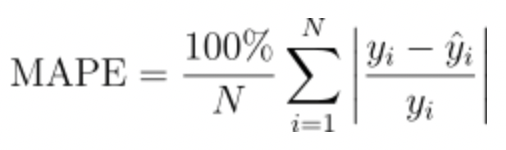

In [ ]:
mae = np.mean([
    abs(result_json[k] - gt[k]) / (abs(gt[k]) + 1e-8)
    for k in pred_keys & gt_keys
])

mape = 100 * mae

print("Mean Absolute Error(MAE):", mae.item())
print("Mean Absolute Percentage Error(MAE):", mape.item())

3. Composite KPI (Overall Score)

* Combine structural and value accuracy into one weighted metric.

* Overall Score = F1(keys) × (1 − MAE)

* This gives a single interpretable number (e.g., 0.85 means “85% overall extraction quality”).

In [ ]:
overall_score = f1 * (1 - mae)
print("Overall Score:", overall_score)